# ML модель для пересчета значений уровня воды на одном гидропосте в значение уровня на другом. От первых шагов до продвинутых моделей.

Задача: разработать модель, которая позволяла бы переводить уровни воды из одного гидропоста (п. Горелуха) в уровни на другом (г. Тихвин). Ошибаться такая модель должна (средняя абсолютная ошибка) в районе 5-7 см. Можем использовать различные дополнительные признаки.

Начнем с того, что подключим нужные библиотки

Сразу оговорюсь, что какие-либо обертки в виде классов и функций я буду использовать только там где это необходимо, так как скорее всего я буду копировать части кода для их последующей модернизации

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, Ridge, PassiveAggressiveRegressor, SGDRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline

Теперь загружаем данные по двум гидропостам - Тихвину и Горелухе

In [3]:
Gor_dataframe = pd.read_excel('/media/mikhail/Data/Water levels Tihvin/Levels_article/Goreluha.xls')
Tih_dataframe = pd.read_excel('/media/mikhail/Data/Water levels Tihvin/Levels_article/Tihvin.xls')
# Посмотрим на таблицу с данными
Gor_dataframe.head(10)

,месяц,день,2013,2014,2015,2016,2017,2018,2019
0,Январь,1,157.0,254.0,199.0,189,285.0,207.0,108.0
1,Январь,2,157.0,254.0,189.0,200,317.0,193.0,103.0
2,Январь,3,159.0,217.0,195.0,197,300.0,194.0,102.0
3,Январь,4,167.0,208.0,203.0,228,263.0,224.0,104.0
4,Январь,5,166.0,188.0,206.0,262,248.0,239.0,106.0
5,Январь,6,177.0,179.0,205.0,278,235.0,236.0,107.0
6,Январь,7,160.0,170.0,205.0,276,221.0,244.0,106.0
7,Январь,8,170.0,171.0,192.0,267,215.0,237.0,107.0
8,Январь,9,163.0,198.0,197.0,250,202.0,211.0,104.0
9,Январь,10,156.0,244.0,183.0,240,215.0,204.0,102.0


In [4]:
# Анализировать такую таблицу неудобно, поэтому мы сведем все значения в один очень длинный вектор
Goreluha = np.array(Gor_dataframe[[2013,2014,2015,2016,2017]])
Goreluha = np.ravel(Goreluha, order = 'F')

# Для Тихвина тоже
Tihvin = np.array(Tih_dataframe[[2013,2014,2015,2016,2017]])
Tihvin = np.ravel(Tihvin, order = 'F')

# Составляем датафрейм
dataframe = pd.DataFrame({'Горелуха': Goreluha,
                          'Тихвин': Tihvin})
# Удаляем все лишнее (в данном случае, это несколько NaN для 29го февраля в невысокосные годы)
dataframe.dropna(inplace = True)

In [5]:
# Теперь добавим категориальный призна - месяц
dataframe['date'] = pd.date_range(start = '01/01/2013', end = '31/12/2017', freq='1D')

# Конструкция довольно страшная... простити
months = []
for i in dataframe['date']:
    i = str(i)
    months.append(i[5:7])        
dataframe['Месяц'] = months
dataframe['Месяц'] = dataframe['Месяц'].map({'01': 'Январь', '02': 'Февраль', '03': 'Март', '04': 'Апрель',
                                             '05': 'Май', '06': 'Июнь', '07': 'Июль', '08': 'Август',
                                             '09': 'Сентябрь', '10': 'Октябрь', '11': 'Ноябрь', '12': 'Декабрь'})

Посмотрим на то, как выглядит наш датасет

In [6]:
dataframe.head(10)

,Горелуха,Тихвин,date,Месяц
0,157.0,97.0,2013-01-01,Январь
1,157.0,110.0,2013-01-02,Январь
2,159.0,110.0,2013-01-03,Январь
3,167.0,109.0,2013-01-04,Январь
4,166.0,104.0,2013-01-05,Январь
5,177.0,96.0,2013-01-06,Январь
6,160.0,93.0,2013-01-07,Январь
7,170.0,92.0,2013-01-08,Январь
8,163.0,97.0,2013-01-09,Январь
9,156.0,102.0,2013-01-10,Январь


Перед началом анализа всегда полезно посмотреть как выглядят наши данные, для этого нарисуем несколько графиков:

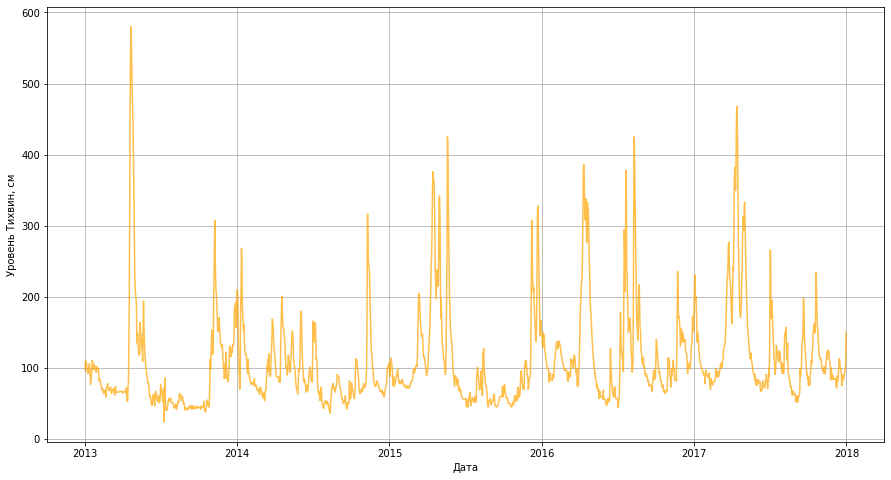

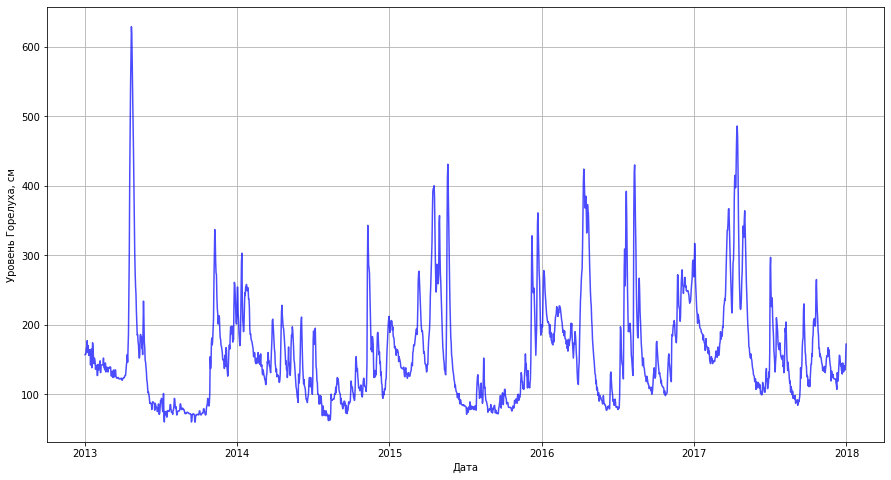

In [7]:
# Сделаем наши графики побольше
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

plt.plot(dataframe['date'], dataframe['Тихвин'], c = 'orange', alpha = 0.7)
plt.xlabel('Дата')
plt.ylabel('Уровень Тихвин, см')
plt.grid()
plt.show()

plt.plot(dataframe['date'], dataframe['Горелуха'], c = 'blue', alpha = 0.7)
plt.xlabel('Дата')
plt.ylabel('Уровень Горелуха, см')
plt.grid()
plt.show()

Выбросов не замечено, приступаем к дальнейшему анализу. И поскольку нам нужно будет строить зависимость уровня воды на гидропосте Тихвин от уровня на Горелухе, то хорошо бы посмотреть как выглядит зависимость.

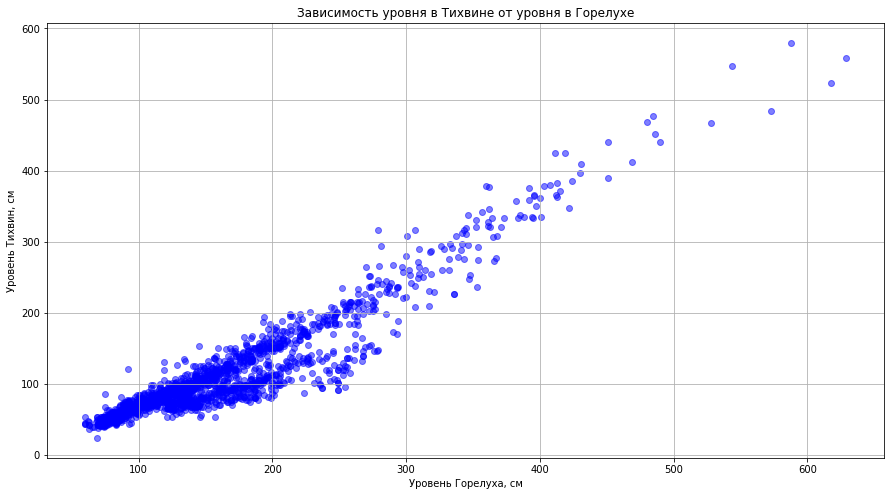

In [8]:
rcParams['figure.figsize'] = 15, 8

plt.scatter(dataframe['Горелуха'], dataframe['Тихвин'], alpha = 0.5, color = 'blue')
plt.title('Зависимость уровня в Тихвине от уровня в Горелухе')
plt.xlabel('Уровень Горелуха, см')
plt.ylabel('Уровень Тихвин, см')
plt.grid()
plt.show()

Зависимость можно было бы аппроксимировать линейно, но скорее всего качество у подобной модели будет неудовлетворительное... Но все же мы уже сейчас можем построить первые варианты нашей модели. Начнем с парной регрессии:

# Парная регрессия

Для этого разбиваем выборку на тренировочный набор и на тестовый.

In [9]:
(X_train, X_test, y_train, y_test) = train_test_split(np.array(dataframe['Горелуха']), 
                                                      np.array(dataframe['Тихвин']),
                                                      test_size = 0.2,
                                                      shuffle = False)

<div align="justify">В коде, приведенном выше, можно заметить, что выборку я не перемешиваю (параметр shuffle = False) в случайном порядке при формировании как обучающей, так и тестовой выборок. Если бы я это сделал, то появился бы следующий момент: модель, по данным из будущего, учится предсказывать уровни из прошлого. Но давайте не будем торопиться, посмотрим как выглядит разбиение на тестовый и тренировочный набор в таком случае.</div>

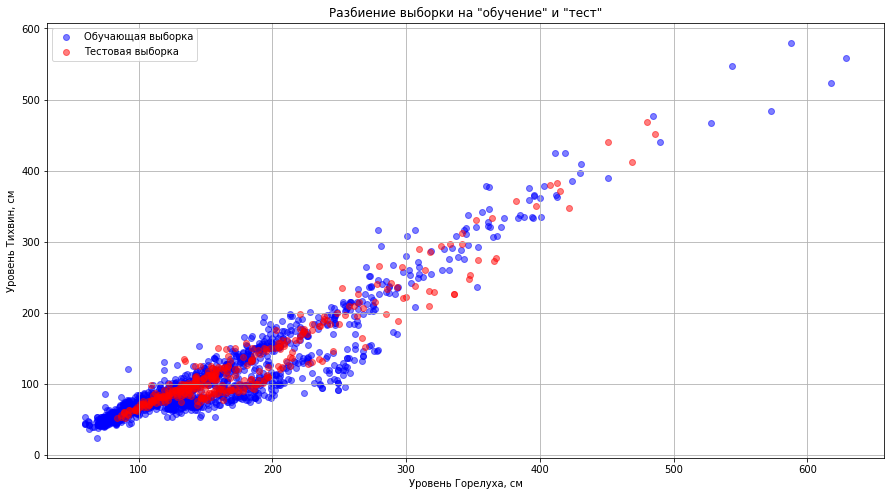

In [10]:
plt.scatter(X_train, y_train, color = 'blue', alpha = 0.5, label = 'Обучающая выборка')
plt.scatter(X_test, y_test, color = 'red', alpha = 0.5, label = 'Тестовая выборка')
plt.title('Разбиение выборки на "обучение" и "тест"')
plt.xlabel('Уровень Горелуха, см')
plt.ylabel('Уровень Тихвин, см')
plt.grid()
plt.legend(loc = 'best')
plt.show()

Теперь обучим модель и выведем получившиеся метрики:

In [11]:
y_train = np.array(y_train).reshape((len(y_train), 1))
y_test = np.array(y_test).reshape((len(y_test), 1))
X_train = np.array(X_train).reshape((len(X_train), 1))
X_test = np.array(X_test).reshape((len(X_test), 1))

# Линейная регрессия
Linear_regressor = LinearRegression()
Linear_regressor.fit(X_train, y_train)
LR_prediction = Linear_regressor.predict(X_test)

In [12]:
# Зададим функцию, которая будет выводить на экран значения метрик
def print_metrics(y_test, prediction, model, r2 = False):
    print('Средняя абсолютная ошибка на отложенной выборке -', mean_absolute_error(y_test, prediction))
    print('Средняя медианная ошибка на отложенной выборке -', median_absolute_error(y_test, prediction))
    print('Корень из среднеквадратической ошибки на отложенной выборке -', mean_squared_error(y_test, prediction)**0.5)
    if r2 == True:
        print('Коэффициент детерминации на обучающей выборке -', r2_score(y_train, model.predict(X_train)))

# Посмотрим как ведет себя модель на новых данных
print_metrics(y_test, LR_prediction, Linear_regressor, r2 = True)

Средняя абсолютная ошибка на отложенной выборке - 14.574186677487633
Средняя медианная ошибка на отложенной выборке - 8.46953027485192
Корень из среднеквадратической ошибки на отложенной выборке - 20.274060700318504
Коэффициент детерминации на обучающей выборке - 0.871293605120022


<div align="justify">Поскольку уровень воды имеет определенный годовой ход, то в один месяц, или сезон, значения уровня будут примерно одинаковыми. Это означает, что проверять мы тогда станем модель на только той части выборки, которая забивается в какой нибудь угол, или как в нашем случае, лежит практически на одной прямой (обратите внимание на графике на прямоугольник, зажатый между уровнями 50-150 по обеим осям).</div>

Поэтому выборку я все же перемешаю, и, скорее всего, качество модели на отложенной выборке несколько упадет.

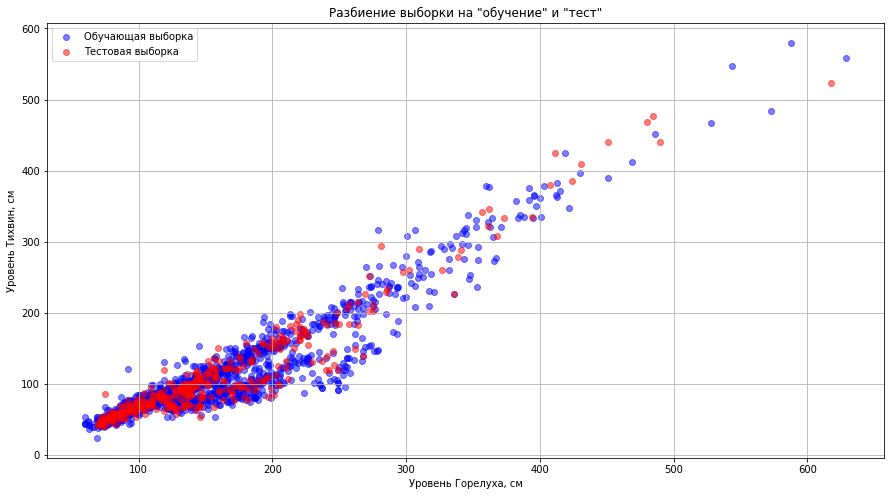

In [13]:
(X_train, X_test, y_train, y_test) = train_test_split(np.array(dataframe['Горелуха']), 
                                                      np.array(dataframe['Тихвин']),
                                                      test_size = 0.2,
                                                      shuffle = True,
                                                      random_state = 10)

plt.scatter(X_train, y_train, color = 'blue', alpha = 0.5, label = 'Обучающая выборка')
plt.scatter(X_test, y_test, color = 'red', alpha = 0.5, label = 'Тестовая выборка')
plt.title('Разбиение выборки на "обучение" и "тест"')
plt.xlabel('Уровень Горелуха, см')
plt.ylabel('Уровень Тихвин, см')
plt.grid()
plt.legend(loc = 'best')
plt.show()

Теперь зададим нашим выборкам нужную форму и обучим на них линейную регрессию

In [14]:
y_train = np.array(y_train).reshape((len(y_train), 1))
y_test = np.array(y_test).reshape((len(y_test), 1))
X_train = np.array(X_train).reshape((len(X_train), 1))
X_test = np.array(X_test).reshape((len(X_test), 1))

# Линейная регрессия
Linear_regressor = LinearRegression()
Linear_regressor .fit(X_train, y_train)
LR_prediction = Linear_regressor.predict(X_test)

# Выводим метрики
print_metrics(y_test, LR_prediction, Linear_regressor, r2 = True)

Средняя абсолютная ошибка на отложенной выборке - 16.733221032951107
Средняя медианная ошибка на отложенной выборке - 10.968929343478123
Корень из среднеквадратической ошибки на отложенной выборке - 23.652530010273637
Коэффициент детерминации на обучающей выборке - 0.875826742664236


Действительно, качество снизилось. И да..., средняя абсолютная ошибка - 16.7 см, это далеко от идеала. Давайте посмотрим на линию регрессии, может она что-нибудь скажет нам.

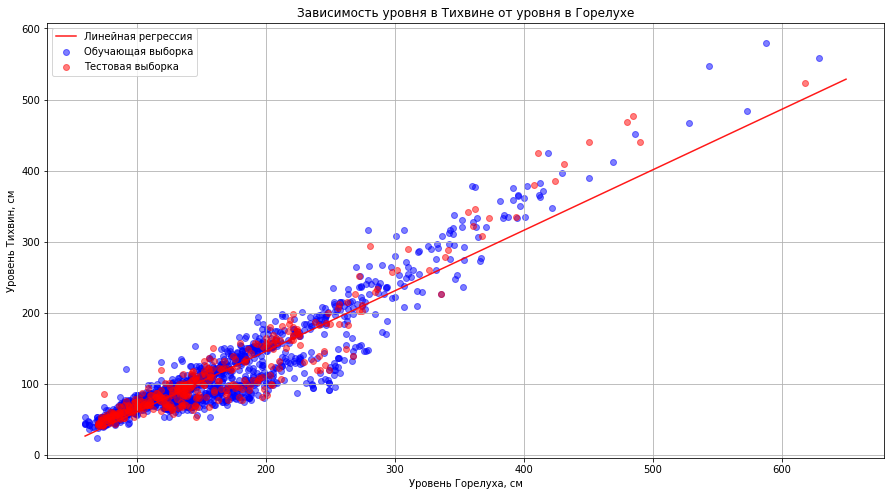

In [15]:
# Зададим две точки, по которым будем рисовать прямую
l = np.array([[60], [650]])

plt.scatter(X_train, y_train, color = 'blue', alpha = 0.5, label = 'Обучающая выборка')
plt.scatter(X_test, y_test, color = 'red', alpha = 0.5, label = 'Тестовая выборка')
plt.plot(l, Linear_regressor.predict(l), color = 'red', alpha = 0.9, label = 'Линейная регрессия')
plt.title('Зависимость уровня в Тихвине от уровня в Горелухе')
plt.xlabel('Уровень Горелуха, см')
plt.ylabel('Уровень Тихвин, см')
plt.grid()
plt.legend(loc = 'best')
plt.show()

<div align="justify">Видимо нам все таки мешает тот "рукав", который лежит ниже регрессионной прямой, его мы никак не угадываем. Первым, что приходит сейчас на ум - добавить категориальный признак (тем более, он уже практически готов к включению в модель). Но пока немного отвлечемся и рассмотрим те методы, которые наиболее часто встречаются в гидрологии. Мы подобрадись к ним, можно сказать вплотную, так что давайте рассмотрим парочку, а уже потом продолжим совершенствовать нашу модель.</div>

# Традиционные методы пересчета в гидрологии

Зависимости подобные той, что мы рассматривали выше, обычно описываются уравнением линейной регрессии, или полиномом 2й, 3й, 4й или реже 5й степени при пересчете гидрологических характеристик.

Итак, начнем мы с того, что линейная регрессия в таких задачах строится не численно, как мы делали выше, а коэффициенты для модели ищутся аналитически. Для чистоты эксперимента сделаем именно так.

In [16]:
Xb = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
w = np.zeros(X_train.shape[1])
z = np.linalg.inv(np.dot(Xb.T, Xb))
w = np.dot(z, np.dot(Xb.T, y_train))

print('Угловой коэффициент -', w[1])
print('Свободный член -', w[0])

Угловой коэффициент - [0.85070109]
Свободный член - [-24.27361199]


In [17]:
# Зададим нашу функцию
def linear_function(x):
    y = - 24.27361199 + 0.85070109*x
    return(y)

predicted_linear = linear_function(X_test)
print_metrics(y_test, predicted_linear, model = None)

Средняя абсолютная ошибка на отложенной выборке - 16.73322089125683
Средняя медианная ошибка на отложенной выборке - 10.968929430000006
Корень из среднеквадратической ошибки на отложенной выборке - 23.652529923227327


Как видно, наше решение ничем не отличается от того, которое мы делали ранее. Таким образом средняя абсолютная ошибка для линейной регрессии составляет 16.7 см. Пусть так, с этого порога мы начнем.

Идем дальше! Впереди мы попытаемся аппроксимировать зависимость полиномом 5й степени.

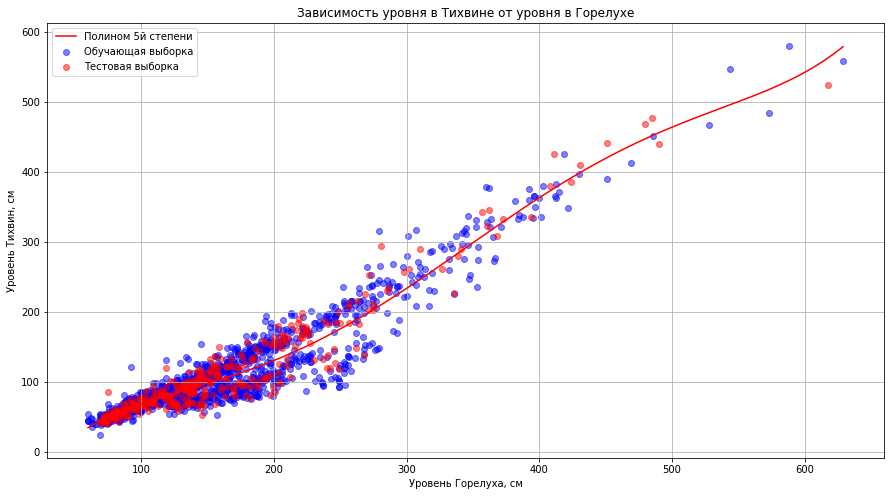

In [18]:
# Подберем коэффициенты полинома
coefs = np.polyfit(np.ravel(X_train), np.ravel(y_train), 5)

pol_x = np.linspace(min(dataframe['Горелуха']), max(dataframe['Горелуха']), num = 1000)
pol_line = np.polyval(coefs, pol_x)

plt.plot(pol_x, pol_line, c = 'red', label = 'Полином 5й степени')
plt.scatter(X_train, y_train, color = 'blue', alpha = 0.5, label = 'Обучающая выборка')
plt.scatter(X_test, y_test, color = 'red', alpha = 0.5, label = 'Тестовая выборка')
plt.title('Зависимость уровня в Тихвине от уровня в Горелухе')
plt.xlabel('Уровень Горелуха, см')
plt.ylabel('Уровень Тихвин, см')
plt.grid()
plt.legend(loc = 'best')
plt.show()

In [19]:
rcParams['figure.figsize'] = 12, 7
# Проверка модели 
predicted_poly = np.polyval(coefs, X_test)

print_metrics(y_test, predicted_poly, model = None)

Средняя абсолютная ошибка на отложенной выборке - 14.433796981426005
Средняя медианная ошибка на отложенной выборке - 10.785220627757624
Корень из среднеквадратической ошибки на отложенной выборке - 19.41084742192501


<div align="justify">Таким образом, традиционные подходы к определению зависимостей уровней на разных гидропостах показывают результат (средняя абсолютная ошибка) в 16.7 см для линейной регрессии и 14.4 см для полиномиальной. Чтобы проверить насколько хорошо модель справлвется с поставленными задачами, нужно посмотреть на распределение ошибок, и на график остатков (эдакий джентельменский набор), но сейчас мы этого делать не будем. Оставим визуализации ошибок на более сложные модели.</div>

А пока постараемся усложнить нашу исходную модель (линейную регрессию).

# Модель множественной линейной регрессии с учетом категориального признака

Давайте для начала визуализируем наш признак. Для таких целей я обычно привык использовать старую добрую библиотеку "seaborn".

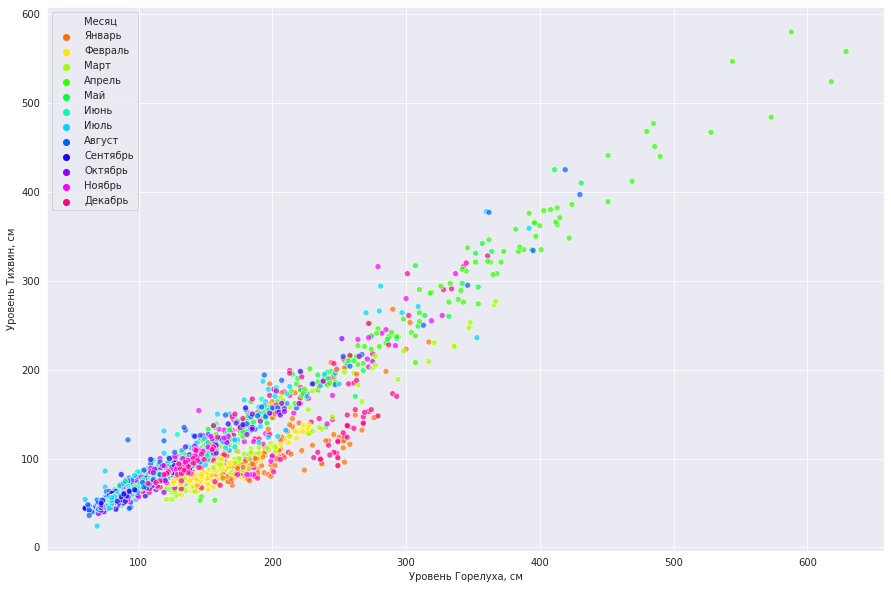

In [20]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(15,10))
    sns.scatterplot(x = 'Горелуха', y = 'Тихвин', hue = 'Месяц',
                    data = dataframe, alpha = 0.7, palette = "hsv", ax = ax)
    ax.set_xlabel('Уровень Горелуха, см')
    ax.set_ylabel('Уровень Тихвин, см')
    plt.show()

Посмотрим на разброс значений в каждом месяце:

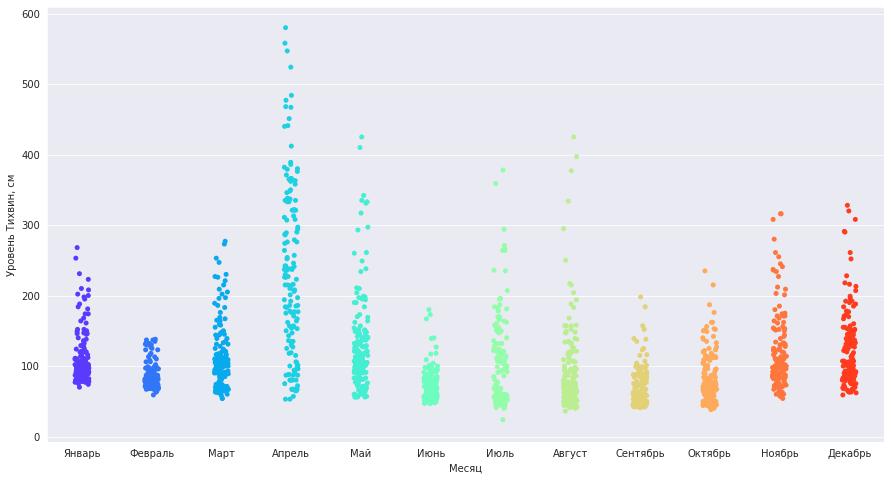

In [21]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize = (15,8))
    sns.stripplot('Месяц', 'Тихвин', palette = "rainbow", data = dataframe, ax = ax)
    ax.set_xlabel('Месяц')
    ax.set_ylabel('Уровень Тихвин, см')
    plt.close(2)
    plt.show()

<div align="justify">Из графика видно, что минимальные значения наблюдаются в июне и июле, - летняя межень и феврале, - зимняя межень. А вот в апреле и мае значения уровня максимальны, так как в это время как правило наблюдается половодье. Всем своим внешним видом категориальный признак месяц говорит нам - "я смогу улучшить вашу модель".</div>

Ну что ж, займемся декодировкой признака. То есть представим наш один категориальный признак, записанный в одном столбце в 12 столбцов, заполненных 1 и 0.

In [22]:
# Декодируем категориальный признак
cat_data = pd.DataFrame(dataframe['Месяц'])
encoder = DV(sparse = False)
encoded_data = encoder.fit_transform(cat_data.T.to_dict().values())

# Нам придется подправить форму матриц
encoded_data = np.array(encoded_data).reshape((len(encoded_data), 12))

(X_train_num, X_test_num, y_train, y_test) = train_test_split(np.array(dataframe['Горелуха']),
                                                              np.array(dataframe['Тихвин']),
                                                              test_size = 0.2,
                                                              shuffle = True,
                                                              random_state = 10)

(X_train_cat, X_test_cat) = train_test_split(encoded_data,
                                             test_size = 0.2,
                                             shuffle = True,
                                             random_state = 10)

Еще немного потанцуем с бубнами, чтобы привести все в удобоваримый для модели формат.

In [23]:
# Подготавливаем данные в нужных размерностях
X_train_num = np.array(X_train_num).reshape((len(X_train_num),1))
X_test_num = np.array(X_test_num).reshape((len(X_test_num),1))
X_train_cat = np.array(X_train_cat).reshape((len(X_train_cat), 12))
X_test_cat = np.array(X_test_cat).reshape((len(X_test_cat), 12))
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

# Объединяем вещественные и категориальные предикторы
X_train = np.hstack((X_train_cat, X_train_num))
X_test = np.hstack((X_test_cat, X_test_num))

Обучим линейную регрессию

In [24]:
# Линейная регрессия
Linear_regressor_with_cat = LinearRegression()
Linear_regressor_with_cat .fit(X_train, y_train)
LR_prediction_with_cat = Linear_regressor_with_cat .predict(X_test)

print_metrics(y_test, LR_prediction_with_cat, Linear_regressor_with_cat , r2 = True)

Средняя абсолютная ошибка на отложенной выборке - 12.033554933941103
Средняя медианная ошибка на отложенной выборке - 6.876379915000371
Корень из среднеквадратической ошибки на отложенной выборке - 17.767266096454225
Коэффициент детерминации на обучающей выборке - 0.9279676149842516


Уже лучше, средняя абсолютная ошибка уменьшилась с 16.7 до 12.0. Но, похоже нам все таки придется включить в модель еще признаков, и выбрать что-нибудь посложнее, чем линейная регрессия.

# Модель множественной линейной регрессии с учетом месяца, температуры и осадков

Немного креатива, и мы получили таблицу с метеоданными на соседней метеостанции.

In [25]:
# Данные с метеостанции
Meteo = pd.read_csv('/media/mikhail/Data/Water levels Tihvin/Levels_article/tihvin_meteo_2013_2019.csv')
# Столбец "date" - нужно перевсти в нужный нам формат
Meteo['date'] = pd.to_datetime(Meteo.date)
# Посмотрим на таблицу
Meteo.head(10)

,station,date,mean_temp,mean_dew_point,sea_level_pressure,station_level_pressure,visibility,mean_wind_speed,max_wind_speed,max_gust_speed,max_temp,min_temp,precip,snow_depth
0,260940-99999,2013-01-01,0.5625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN
1,260940-99999,2013-01-02,1.1750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN
2,260940-99999,2013-01-03,0.6375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.3,NaN
3,260940-99999,2013-01-04,-0.6750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,260940-99999,2013-01-05,-3.2125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.3,NaN
5,260940-99999,2013-01-06,-6.8250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2,NaN
6,260940-99999,2013-01-07,-6.0125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
7,260940-99999,2013-01-08,-8.9625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
8,260940-99999,2013-01-09,-7.2875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
9,260940-99999,2013-01-10,-8.1125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5,NaN


Теперь нам нужно объединить наши таблицы.

In [26]:
# Создаем новый столбец в таблице с данными об уровнях
dataframe['date'] = pd.date_range(start = '01/01/2013', end='31/12/2017', freq='1D')
# По этому столбцу производим слияние таблиц
data = pd.merge(dataframe, Meteo, on='date')

Мы планируем использовать данные об осадках и температуре, поэтому неплохо бы взгянуть на то, как наши признаки ложатся на график.

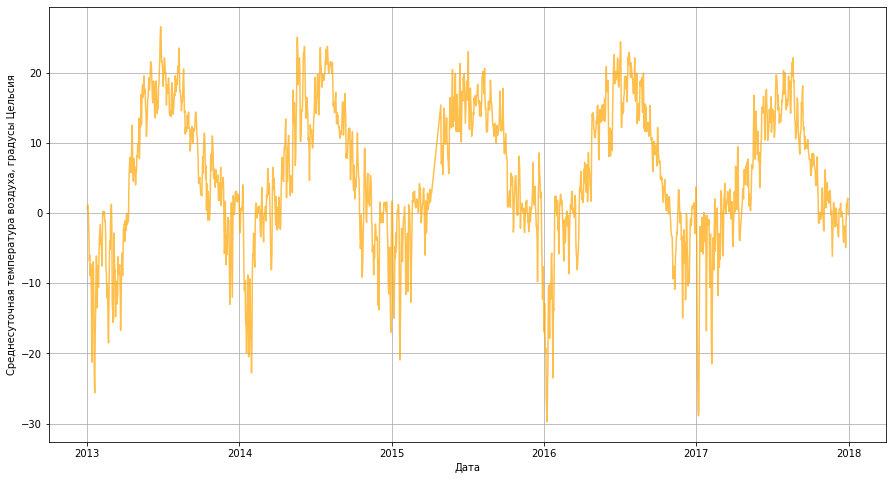

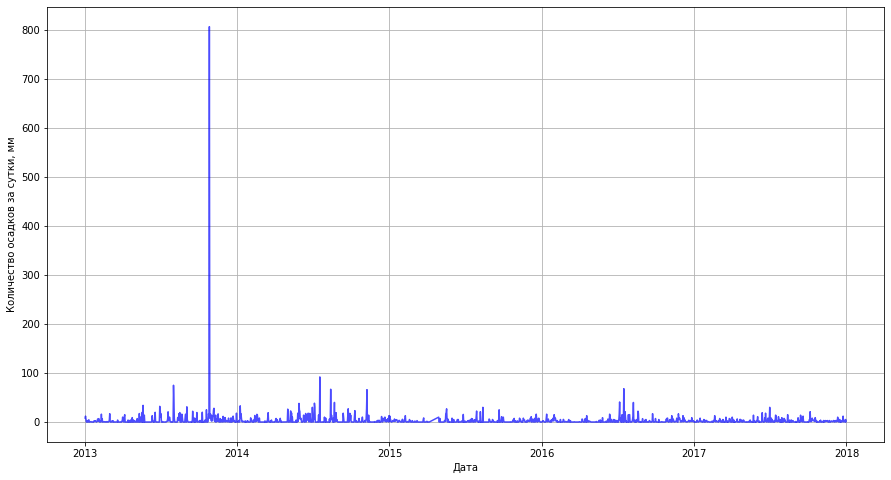

In [27]:
rcParams['figure.figsize'] = 15, 8

plt.plot(data['date'], data['mean_temp'], c = 'orange', alpha = 0.7)
plt.xlabel('Дата')
plt.ylabel('Среднесуточная температура воздуха, градусы Цельсия')
plt.grid()
plt.show()

plt.plot(data['date'], data['precip'], c = 'blue', alpha = 0.7)
plt.xlabel('Дата')
plt.ylabel('Количество осадков за сутки, мм')
plt.grid()
plt.show()

С температурой все в порядке, а вот значение в более чем 800 мм осадков вяглядит крайне неправдоподобно - у нас в ряду выброс.

In [28]:
print('Максимальное значение уровня', max(data['precip']))

Максимальное значение уровня 807.0


In [29]:
# Ограничимся данными о температуре, осадках, месяце, и, собственно, уровнях (остальные уберем, чтобы не смущали)
dataset = pd.DataFrame(data[['Месяц', 'Горелуха', 'Тихвин', 'mean_temp', 'precip', 'date']])
# Убираем выброс (807 мм за один день - это чересчур много)
dataset['precip'].replace(807.0, np.nan, inplace = True)
dataset.dropna(inplace = True)

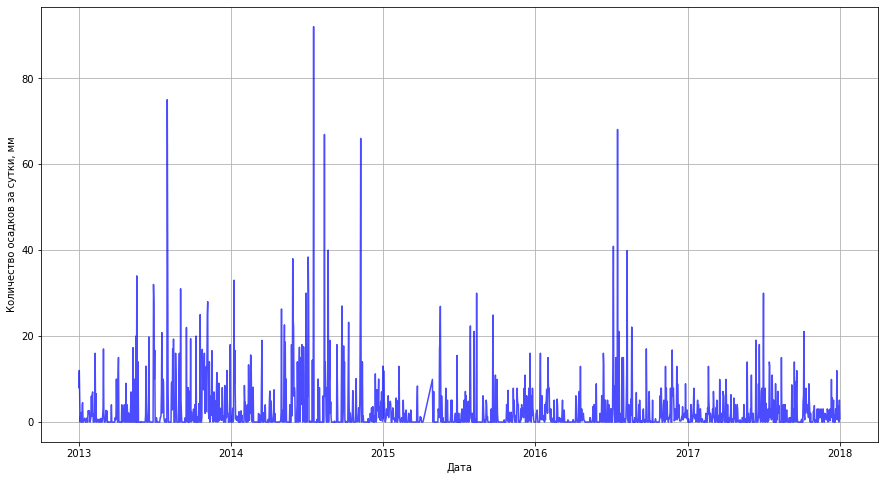

In [30]:
plt.plot(dataset['date'], dataset['precip'], c = 'blue', alpha = 0.7)
plt.xlabel('Дата')
plt.ylabel('Количество осадков за сутки, мм')
plt.grid()
plt.show()

<div align="justify">Прекрасно, больше выбросов не видно! Добавим в модель два признака: Температуру и Осадки. Так как теперь мы рабтаем с новыми данными (некоторые точки из анализа пропали потому что не было данных по осадкам, или температуре, их немного, но все же), поэтому повторим нашу процедуру подготовки данных.</div>


Стоит обратить внимание, что так как вещественные признаки у нас в разных размерностях, то необходимо провести их стандартизацию.

In [31]:
# Декодируем категориальный признак
cat_data = pd.DataFrame(dataset['Месяц'])
encoder = DV(sparse = False)
encoded_data = encoder.fit_transform(cat_data.T.to_dict().values())

# Нам придется подправить форму матриц
encoded_data = np.array(encoded_data).reshape((len(encoded_data), 12))

# Выборку необходимо стандартизовать
scaler = StandardScaler()
(X_train_num, X_test_num, y_train, y_test) = train_test_split(scaler.fit_transform(dataset[['Горелуха' , 'mean_temp', 'precip']]),
                                                              np.array(dataset['Тихвин']),
                                                              test_size = 0.2,
                                                              shuffle = True,
                                                              random_state = 10)

(X_train_cat, X_test_cat) = train_test_split(encoded_data,
                                             test_size = 0.2,
                                             shuffle = True,
                                             random_state = 10)

# Подготавливаем данные в нужных размерностях
X_train_num = np.array(X_train_num).reshape((len(X_train_num),3))
X_test_num = np.array(X_test_num).reshape((len(X_test_num),3))
X_train_cat = np.array(X_train_cat).reshape((len(X_train_cat), 12))
X_test_cat = np.array(X_test_cat).reshape((len(X_test_cat), 12))
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

# Объединяем вещественные и категориальные предикторы
X_train = np.hstack((X_train_cat, X_train_num))
X_test = np.hstack((X_test_cat, X_test_num))

# Обучаем модель на новых данных
Full_linear_regression = LinearRegression()
Full_linear_regression.fit(X_train, y_train)
Full_LR_prediction = Full_linear_regression.predict(X_test)

print_metrics(y_test, Full_LR_prediction, Full_linear_regression, r2 = True)

Средняя абсолютная ошибка на отложенной выборке - 12.353553497229917
Средняя медианная ошибка на отложенной выборке - 8.26171875
Корень из среднеквадратической ошибки на отложенной выборке - 18.03077833032281
Коэффициент детерминации на обучающей выборке - 0.9289849088523819


<div align="justify">А вот здесь стоит призадуматься. Мы добавили целых два признака, которые по своей природе должны определять уровень воды в реке (количество выпавших осадков определяет питание реки, а температура воздуха - испарение влаги с водросборного бассейна). А вот прироста качества совсем нет - стало даже немного хуже. По сути, все что мы сделали - внесли шума в нашу обучающую выборку.</div>

Попробуем разобраться, в чем же проблема.

# Синтез новых признаков

Ответ здесь, возможно, в следующем: данные характеристики мы брали за один отдельно взятый момент времени. Однако, для реки "важнее" то, что она получила не в данный момент времени, скажем, 100 мм осадков, а то, сколько их было в течение 7, 10, 30 дней и т.д. Поэтому мы подготовим новые признаки:
- Среднее значение температур за 10 суток
- Амплитуда температуры воздуха за 10 суток
- Сумма осадков за 10 суток
- Дисперсия осадков по выборке за 10 суток

In [32]:
# Среднее значение температуры за 10 суток до наблюдения
mean_temp = np.array(dataset['mean_temp'])
average10_tmp = []
amplitude10_tmp = []
# Теперь займемся осадками
precip = np.array(dataset['precip'])
precip10_sum = []
precip10_var = []
for i in range(0, len(mean_temp)):
    if any(i == element for element in [0,1,2,3,4,5,6,7,8,9,10]):
        average = None
        amplitude = None
        precip_sum = None
        precip_var = None
    else:
        # Собираем в список предшествующие наблюдению данные за 10 суток
        # Температура
        list_with_temperatures = []
        for number in range(1, 11):
            list_with_temperatures.append(mean_temp[i-number])
        list_with_temperatures = np.array(list_with_temperatures)
        # Расчет средней температуры
        average = np.mean(list_with_temperatures)
        # Расчет аплитуды температуры
        minimum = min(list_with_temperatures)
        maximum = max(list_with_temperatures)
        amplitude = maximum - minimum

        # Сумма осадков и дисперсия
        list_with_precip = []
        for number in range(1, 11):
            list_with_precip.append(precip[i-number])
        list_with_precip = np.array(list_with_precip)
        precip_sum = np.sum(list_with_precip)
        precip_var = np.var(list_with_precip)

    # Признаки по температуре
    amplitude10_tmp.append(amplitude)
    average10_tmp.append(average)
    # Признаки по осадкам
    precip10_sum.append(precip_sum)
    precip10_var.append(precip_var)

dataset['average10_tmp'] = pd.Series(average10_tmp)
dataset['amplitude10_tmp'] = pd.Series(amplitude10_tmp)
dataset['precip10_sum'] = pd.Series(precip10_sum)
dataset['precip10_var'] = pd.Series(precip10_var)
dataset.dropna(inplace = True)

Новые признаки готовы, заново подготвим наши тестовый и обучающий наборы данных с учетом уже новых сгенерированных нами признаков. Старые признаки (температуру и осадки) мы уберем.

In [33]:
# Декодируем категориальный признак
cat_data = pd.DataFrame(dataset['Месяц'])
encoder = DV(sparse = False)
encoded_data = encoder.fit_transform(cat_data.T.to_dict().values())

# Нам придется подправить форму матриц
encoded_data = np.array(encoded_data).reshape((len(encoded_data), 12))

scaler = StandardScaler()
(X_train_num, X_test_num, 
 y_train, y_test) = train_test_split(scaler.fit_transform(dataset[['Горелуха' ,'average10_tmp',
                                                                   'amplitude10_tmp', 'precip10_sum',
                                                                   'precip10_var']]),
                                                              np.array(dataset['Тихвин']),
                                                              test_size = 0.2,
                                                              shuffle = True,
                                                              random_state = 10)

(X_train_cat, X_test_cat) = train_test_split(encoded_data,
                                             test_size = 0.2,
                                             shuffle = True,
                                             random_state = 10)

# Подготавливаем данные в нужных размерностях
X_train_num = np.array(X_train_num).reshape((len(X_train_num),5))
X_test_num = np.array(X_test_num).reshape((len(X_test_num),5))
X_train_cat = np.array(X_train_cat).reshape((len(X_train_cat), 12))
X_test_cat = np.array(X_test_cat).reshape((len(X_test_cat), 12))
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)
# Объединяем вещественные и категориальные предикторы
X_train = np.hstack((X_train_cat, X_train_num))
X_test = np.hstack((X_test_cat, X_test_num))

In [34]:
Full_linear_regression = LinearRegression()
Full_linear_regression.fit(X_train, y_train)
Full_LR_prediction = Full_linear_regression.predict(X_test)

print_metrics(y_test, Full_LR_prediction, Full_linear_regression, r2 = True)

Средняя абсолютная ошибка на отложенной выборке - 10.992437761142062
Средняя медианная ошибка на отложенной выборке - 8.3125
Корень из среднеквадратической ошибки на отложенной выборке - 15.266909800680855
Коэффициент детерминации на обучающей выборке - 0.9322355254989584


Пока посмотрим на гистограмму ошибок (а точнее на график ядерной оценки плотности) и график остатков.

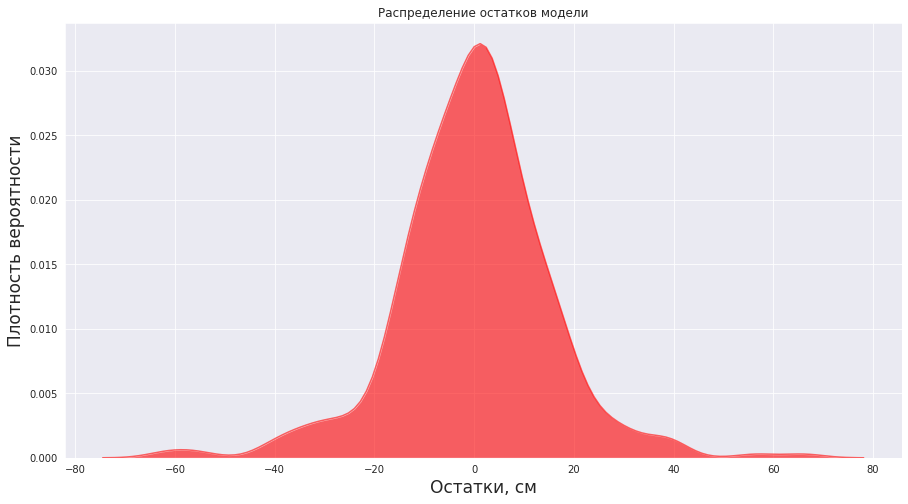

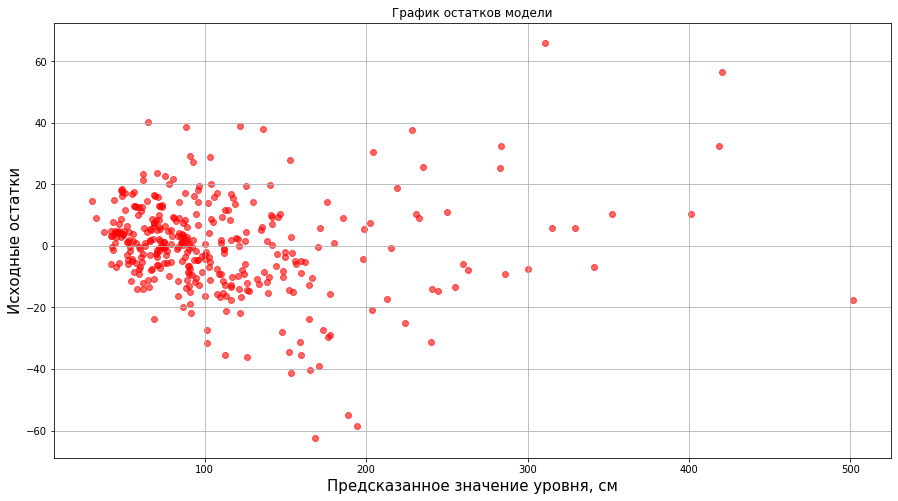

In [37]:
# Зададим функцию для отрисовки графиков
def residuals_plots(y_test, prediction, color = 'blue'):
    # Рассчитываем остатки модели - действительное минус предсказанное
    residuals = y_test - prediction
    with sns.axes_style("darkgrid"):
        sns.kdeplot(residuals, shade = True, color = color,  kernel = 'gau', alpha = 0.6)
        plt.title('Распределение остатков модели')
        plt.ylabel('Плотность вероятности', fontsize = 17)
        plt.xlabel('Остатки, см', fontsize = 17)
        plt.show()

    plt.scatter(prediction, residuals, c = color, alpha = 0.6)
    plt.title('График остатков модели')
    plt.xlabel('Предсказанное значение уровня, см', fontsize = 15)
    plt.ylabel('Исходные остатки', fontsize = 15)
    plt.grid()
    plt.show()

# Посмотрим на остатки модели
residuals_plots(y_test, Full_LR_prediction, color = 'red')

<div align="justify">Исходя из графиков, распределение остатков немного смещено выше нуля, однородность дисперсии остатков не соблюдается. Да и качество неудовлетворительное, но уже сейчас мы можем подвести некоторые итоги.</div>

### Промежуточные итоги

<div align="justify">В результате проделанной работы нам удалось улучшить качество (MAE) модели на отложенной выборке с 16.7 до 11.0 см. Начинали мы с парной линеной регрессии, учитывающей только лишь уровень реки на одном гидропосте. Закончили мы применением множественной линейной регрессии с использованием, помимо уровня реки на гидропосте, категориального признака (месяц), а также синтезированных признаков (сумма осадков за предшествующие 10 суток, дисперсия выборки осадков за предшествующие 10 суток, среднее значение температуры воздуха за предшествующие 10 суток, амплитуда температуры воздуха за предшествующие наблюдению 10 суток).</div>

Но нужное качество модели не достигнуто, поэтому двигаемся дальше.

# Выбор наиболее точной модели. Настройка гиперпараметров.

Ранее мы использовали только лишь модель линейной регрессии. Однако, я уверен, для нашей задачи могут подойти и более продвинутые модели машинного обучения, например, метод опорных векторов или случаный лес. Лучше всего попробовать несколько алгоритмов машинного обучения, а затем выбрать наиболее успешный.

In [38]:
def GridSearch_and_metrics(X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test):
    # Гребневая регрессия
    alphas = [0.01, 0.1, 1.0, 10, 20, 30]
    param_grid = {'alpha': alphas}
    # Задаем модель, которую будем обучать
    estimator = Ridge()
    # Производим обучение модели с заданными вариантами параметров (осуществляем поиск по сетке)
    optimizer = GridSearchCV(estimator, param_grid, iid = 'deprecated', cv = 3, scoring = 'neg_mean_absolute_error')
    optimizer.fit(X_train, y_train)
    Ridge_regression = optimizer.best_estimator_
    Ridge_predicted = Ridge_regression.predict(X_test)
    
    print('\n')
    print('Значение ошибки по кросс-валидации для гребневой регрессии -', abs(optimizer.best_score_))
    print('Лучшие параметры модели: ', optimizer.best_params_)
    print_metrics(y_test, Ridge_predicted, Ridge_regression, r2 = True)

    # K-ближайших соседей с поиском по сетке
    weights = ['uniform', 'distance']
    algorithm = ['auto', 'kd_tree']
    n_neighbors = [2, 3, 5]
    param_grid = {'weights': weights, 'n_neighbors': n_neighbors, 'algorithm': algorithm}
    # Задаем модель, которую будем обучать
    estimator = KNeighborsRegressor()
    # Производим обучение модели с заданными вариантами параметров (осуществляем поиск по сетке)
    optimizer = GridSearchCV(estimator, param_grid, cv = 3, iid = 'deprecated', scoring = 'neg_mean_absolute_error')
    optimizer.fit(X_train, y_train)
    KNeighbors = optimizer.best_estimator_
    KNeighbors_predicted = KNeighbors.predict(X_test)
    
    print('\n')
    print('Значение ошибки по кросс-валидации для K-ближайших соседей -', abs(optimizer.best_score_))
    print('Лучшие параметры модели: ', optimizer.best_params_)
    print_metrics(y_test, KNeighbors_predicted, KNeighbors, r2 = True)
    
    # Случайный лес 
    max_depth = [5, 10, 15, 20, 25]
    min_samples_split = [2, 5, 10]
    max_leaf_nodes = [10, 50, 100]
    param_grid = {'max_depth': max_depth, 'min_samples_split': min_samples_split,'max_leaf_nodes': max_leaf_nodes}
    # Задаем модель, которую будем обучать
    estimator = RandomForestRegressor(n_estimators = 500, n_jobs = -1)
    # Производим обучение модели с заданными вариантами параметров (осуществляем поиск по сетке)
    optimizer = GridSearchCV(estimator, param_grid, cv = 3, iid = 'deprecated', scoring = 'neg_mean_absolute_error')
    optimizer.fit(X_train, np.ravel(y_train))
    RandomForest_regression = optimizer.best_estimator_
    RandomForest_predicted = RandomForest_regression.predict(X_test)
    
    print('\n')
    print('Значение ошибки по кросс-валидации для случайного леса -', abs(optimizer.best_score_))
    print('Лучшие параметры модели: ', optimizer.best_params_)
    print_metrics(y_test, RandomForest_predicted, RandomForest_regression, r2 = True)
        
    # Метод опорных векторов с поиском по сетке
    Cs = [0.01, 0.1, 1, 10, 100, 1000, 1500]
    epsilons = [0.1, 0.4, 0.7, 1.0, 10]
    param_grid = {'C': Cs, 'epsilon': epsilons}
    # Задаем модель, которую будем обучать
    estimator = SVR(kernel = 'rbf', gamma = 'scale')
    # Производим обучение модели с заданными вариантами параметров (осуществляем поиск по сетке)
    optimizer = GridSearchCV(estimator, param_grid, cv = 3, iid = 'deprecated', scoring = 'neg_mean_absolute_error')
    optimizer.fit(X_train, np.ravel(y_train))
    SVM_regression = optimizer.best_estimator_
    SVM_predicted = SVM_regression.predict(X_test)
    
    print('\n')
    print('Значение ошибки по кросс-валидации для метода опорных векторов -', abs(optimizer.best_score_))
    print('Лучшие параметры модели: ', optimizer.best_params_)
    print_metrics(y_test, SVM_predicted, SVM_regression, r2 = True)

# Применим заготовленную функцию на наших данных
GridSearch_and_metrics(X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)



Значение ошибки по кросс-валидации для гребневой регрессии - 12.641273547110577
Лучшие параметры модели:  {'alpha': 10}
Средняя абсолютная ошибка на отложенной выборке - 10.95964713020359
Средняя медианная ошибка на отложенной выборке - 8.095279327164022
Корень из среднеквадратической ошибки на отложенной выборке - 15.294565426790143
Коэффициент детерминации на обучающей выборке - 0.9320973082282858


Значение ошибки по кросс-валидации для K-ближайших соседей - 10.53402247477367
Лучшие параметры модели:  {'algorithm': 'auto', 'n_neighbors': 2, 'weights': 'distance'}
Средняя абсолютная ошибка на отложенной выборке - 9.1749066012659
Средняя медианная ошибка на отложенной выборке - 4.8724940806961285
Корень из среднеквадратической ошибки на отложенной выборке - 14.99818963265374
Коэффициент детерминации на обучающей выборке - 1.0


Значение ошибки по кросс-валидации для случайного леса - 9.136640027446857
Лучшие параметры модели:  {'max_depth': 15, 'max_leaf_nodes': 100, 'min_samples_sp

Таким образом наиболее точным оказался метод опорных векторов с гиперпараметрами "kernel = 'rbf', gamma = 'scale', C = 1500, epsilon = 1.0". Это очень хороший результат, заменив линейную регрессию на метод опорных векторов мы смогли значительно улучшить качество модели (средняя абсолютная ошибка сократилась с 11.0 до 7.1 см).

# Анализ остатков и дальнейшее совершенствование модели

Посмотрим на график остатков модели (так же, как мы делали ранее):

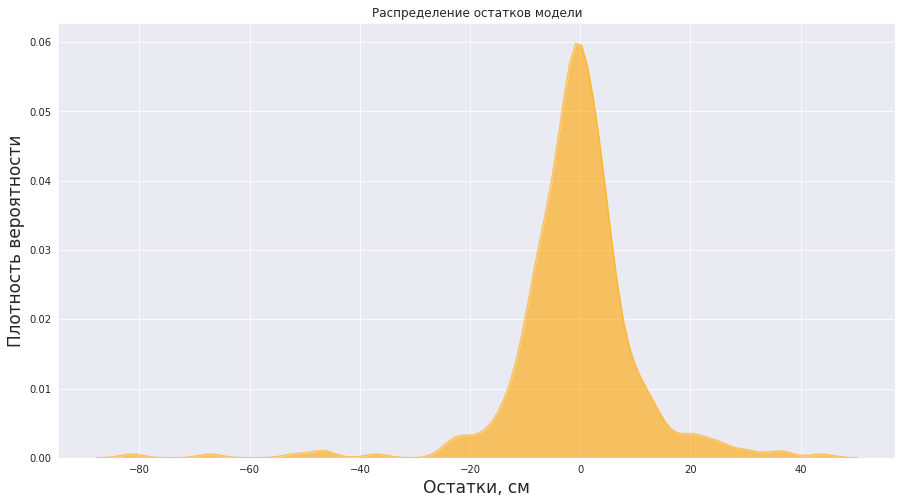

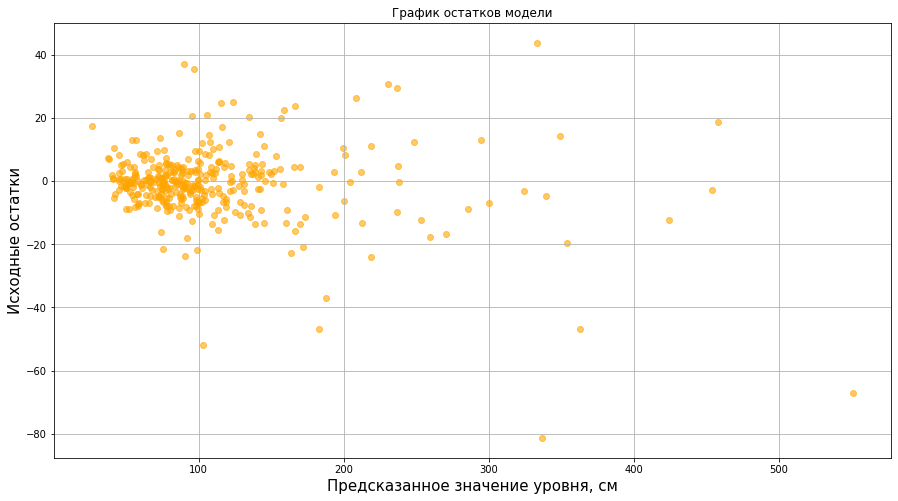

In [39]:
SVM_regression = SVR(kernel = 'rbf', gamma = 'scale', C = 1500, epsilon = 1.0)
SVM_regression.fit(X_train, np.ravel(y_train))
SVM_predicted = SVM_regression.predict(X_test)

residuals_plots(y_test, SVM_predicted, color = 'orange')

<div align="justify">Теперь остановимся на пару минут и попробуем проанализировать результаты. Нам удалось улучшить качество работы алгоритма на отложенной выборке путем замены алгоритма линейной регрессии на метод опорных векторов. Однако, по графику остатков видно, что на некоторых значениях уровня воды модель может ошибаться очень сильно. В данном кейсе мы пытаемся предугадать угрозу наводнения, поэтому ошибки в 80 см - это чересчур много, несмотря на то, что формально, мы приблизились к заявленному в задаче порогу точности.</div>

Поэтому предлагаю рассмотреть объект, для которого модель ошибается почти на целый метр (величина ошибки - чуть более 80 (на графике это значение соответствует остатку, равному значению чуть менее -80))

In [41]:
errors = SVM_predicted - y_test
# Индекс наибольшего значения остатка
index = np.argwhere(errors > 80)[0][0]
print('Индекс элемента в тестовой выборке -', index)

# Посмотрим какому отклику должна соответствовать данная точка
print('Действительное значение уровня', y_test[index])
print('Предсказанное значение уровня', SVM_predicted[index])

Индекс элемента в тестовой выборке - 234
Действительное значение уровня 255.0
Предсказанное значение уровня 336.3886550417612


Да, действительно что-то не так. Давайте посмотрим какому объекту в датасете соответсвует значение уровня в Тихвине - 255.0 см.

In [47]:
tih = dataset['Тихвин']
tih = np.array(tih)
print('Индекс строки, для которой модель дает неточные предсказания -', np.argwhere(tih == 255.0)[0][0])

Индекс строки, для которой модель дает неточные предсказания - 667


Теперь давайте рассмотрим какая ситуация у нас была за несколько дней до и после наблюдения. Для этого нанесем на график уровень воды на двух гидропостах и осадки.

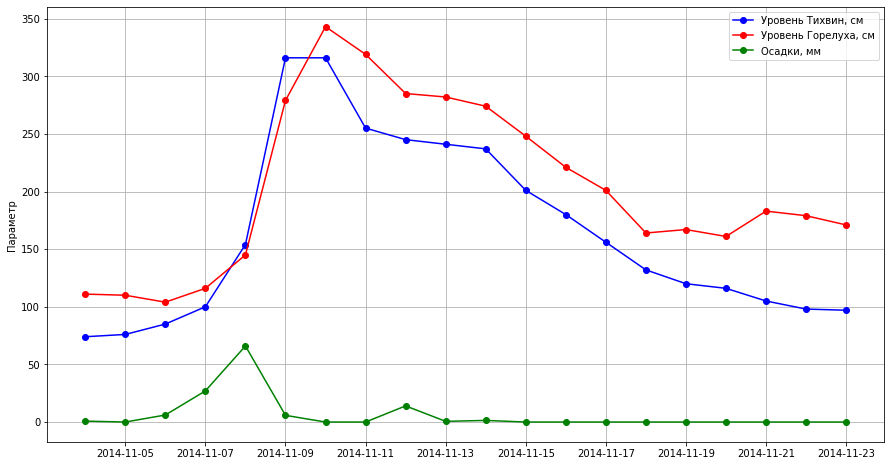

In [48]:
df = pd.DataFrame(dataset[660:680])
plt.plot(df['date'],df['Тихвин'], '-ok', c = 'blue', label = 'Уровень Тихвин, см')
plt.plot(df['date'],df['Горелуха'], '-ok', c = 'red', label = 'Уровень Горелуха, см')
plt.plot(df['date'],df['precip'], '-ok', c = 'green', label = 'Осадки, мм')
plt.grid()
plt.ylabel('Параметр')
plt.legend(loc = 'best')
plt.show()

Как видно из графика, у нас случился перескок кривых уровней. То есть примерно 8го ноября 2014 года уровень на Тихвине неожиданно (а поверьте, это необычная ситуация) превысил уровень на Горелухе. Такая ситуация прдолжалась несколько дней до 10го ноября 2014го. Возможно, причиной подобного явления стали выпавшие в большом количестве осадки (см. пик зеленой кривой на 8е ноября).

Поэтому в модель было решено включить допонительный категориальный предиктор, который принимает значения, равные 1, если за предыдущие сутки разность уровня воды на Горелухе и уровня воды на Тихвине была больше нуля, и значения равные 0, если за предыдущие сутки разность уровня воды на Горелухе и уровня воды на Тихвине была меньше нуля.

Подобный подход оправдывался следующим наблюдением в данных: уровень воды на Горелухе в подавляющем большинстве случаев выше, чем уровень воды в Тихвине. Это связано с тем, что Горелуха расположена ниже по течению (то есть, в участок реки между Тихвином и Горелухой впадают некоторые небольшие притоки, которые делают реку более полноводной). Однако в некоторых случаях уровень в Тихвине был выше, что можно объяснить пространственной неоднородностью выпадающих осадков. Для учета таких краткосрочных изменений было решено включить в модель новый предиктор, который бы позволял это сделать.  

Ниже мы произведем подготовку исходных данных одним блоком и заново обучим метод опорных векторов с подбором гиперпараметров по сетке.

In [50]:
# Данные с метеостанции
Meteo = pd.read_csv('/media/mikhail/Data/Water levels Tihvin/Levels_article/tihvin_meteo_2013_2019.csv')
# Столбец "date" - нужно перевсти в нужный нам формат
Meteo['date'] = pd.to_datetime(Meteo.date)
# Создаем новый столбец в таблице с данными об уровнях
dataframe['date'] = pd.date_range(start = '01/01/2013', end='31/12/2017', freq='1D')
# По этому столбцу производим слияние таблиц
data = pd.merge(dataframe, Meteo, on='date')
# Ограничимся данными о температуре, осадках, месяце, и, собственно, уровнях (остальные уберем, чтобы не смущали)
dataset = pd.DataFrame(data[['Месяц', 'Горелуха', 'Тихвин', 'mean_temp', 'precip', 'date']])
# Убираем выброс (807 мм за один день - это чересчур много)
dataset['precip'].replace(807.0, np.nan, inplace = True)
dataset.dropna(inplace = True)

# Среднее значение температуры за 10 суток до наблюдения
mean_temp = np.array(dataset['mean_temp'])
average10_tmp = []
amplitude10_tmp = []
# Теперь займемся осадками
precip = np.array(dataset['precip'])
precip10_sum = []
precip10_var = []
tih = np.array(dataset['Тихвин'])
gor = np.array(dataset['Горелуха'])
diff = []
for i in range(0, len(mean_temp)):
    if any(i == element for element in [0,1,2,3,4,5,6,7,8,9,10]):
        average = None
        amplitude = None
        precip_sum = None
        precip_var = None
        dif = None
    else:
        list_with_temperatures = []
        for number in range(1, 11):
            list_with_temperatures.append(mean_temp[i-number])
        list_with_temperatures = np.array(list_with_temperatures)
        # Расчет средней температуры
        average = np.mean(list_with_temperatures)
        # Расчет аплитуды температуры
        minimum = min(list_with_temperatures)
        maximum = max(list_with_temperatures)
        amplitude = maximum - minimum

        # Сумма осадков и дисперсия
        list_with_precip = []
        for number in range(1, 11):
            list_with_precip.append(precip[i-number])
        list_with_precip = np.array(list_with_precip)
        precip_sum = np.sum(list_with_precip)
        precip_var = np.var(list_with_precip)
        
        # Значение разности показателей
        razn = gor[i-1] - tih[i-1] # уровень на Горелухе обычно больше
        if razn > 0:
            dif = 1
        else:
            dif = 0

    # Признаки по температуре
    amplitude10_tmp.append(amplitude)
    average10_tmp.append(average)
    # Признаки по осадкам
    precip10_sum.append(precip_sum)
    precip10_var.append(precip_var)
    # Разность уровней
    diff.append(dif)

dataset['average10_tmp'] = pd.Series(average10_tmp)
dataset['amplitude10_tmp'] = pd.Series(amplitude10_tmp)
dataset['precip10_sum'] = pd.Series(precip10_sum)
dataset['precip10_var'] = pd.Series(precip10_var)
dataset['diff'] = pd.Series(diff)
dataset.dropna(inplace = True)

# Декодируем категориальный признак
cat_data = pd.DataFrame(dataset[['Месяц','diff']])
encoder = DV(sparse = False)
encoded_data = encoder.fit_transform(cat_data.T.to_dict().values())

# Нам придется подправить форму матриц
encoded_data = np.array(encoded_data).reshape((len(encoded_data), 13))

scaler = StandardScaler()
(X_train_num, X_test_num, 
 y_train, y_test) = train_test_split(scaler.fit_transform(dataset[['Горелуха', 'average10_tmp',
                                                                   'amplitude10_tmp', 'precip10_sum',
                                                                   'precip10_var']]),
                                                              np.array(dataset['Тихвин']),
                                                              test_size = 0.2,
                                                              shuffle = True,
                                                              random_state = 10)

(X_train_cat, X_test_cat) = train_test_split(encoded_data,
                                             test_size = 0.2,
                                             shuffle = True,
                                             random_state = 10)

# Подготавливаем данные в нужных размерностях
X_train_num = np.array(X_train_num).reshape((len(X_train_num),5))
X_test_num = np.array(X_test_num).reshape((len(X_test_num), 5))
X_train_cat = np.array(X_train_cat).reshape((len(X_train_cat), 13))
X_test_cat = np.array(X_test_cat).reshape((len(X_test_cat), 13))
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)
# Объединяем вещественные и категориальные предикторы
X_train = np.hstack((X_train_cat, X_train_num))
X_test = np.hstack((X_test_cat, X_test_num))

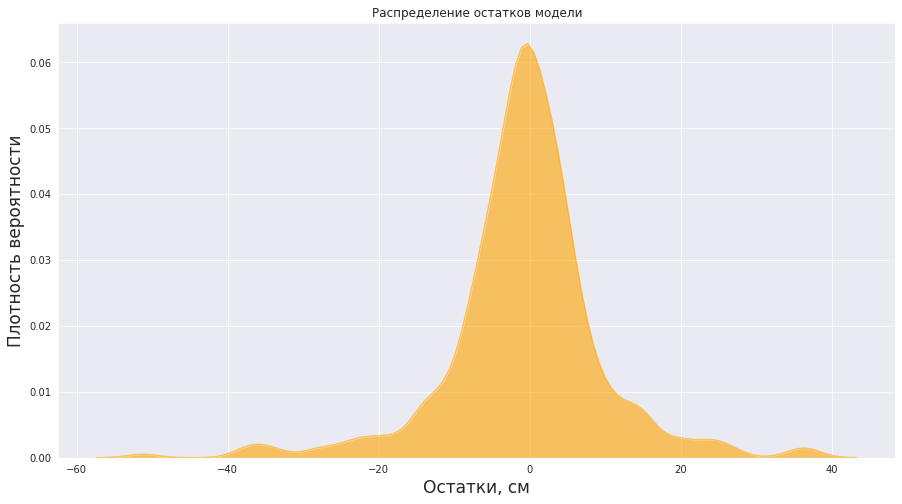

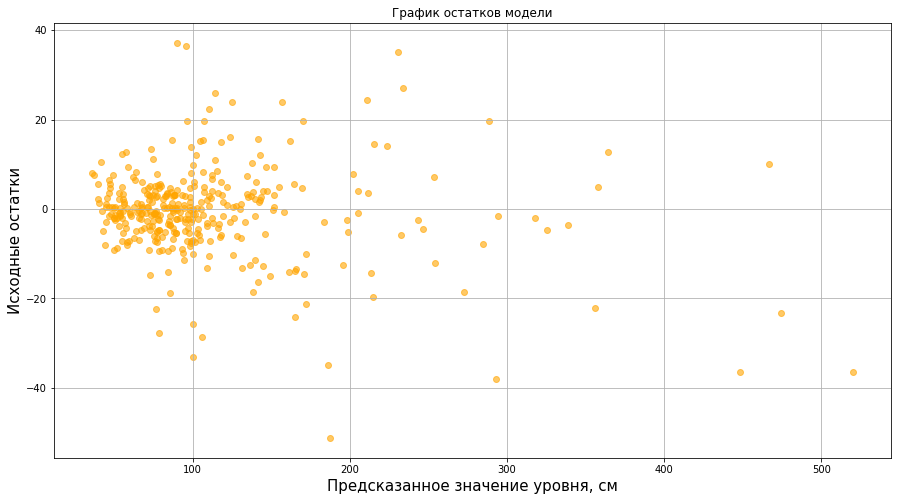

Значение ошибки по кросс-валидации для метода опорных векторов - 8.503826234969347
Лучшие параметры модели:  {'C': 1000, 'epsilon': 1.0}
Средняя абсолютная ошибка на отложенной выборке - 6.730365027911471
Средняя медианная ошибка на отложенной выборке - 4.210530247029197
Корень из среднеквадратической ошибки на отложенной выборке - 10.200402662664832
Коэффициент детерминации на обучающей выборке - 0.9855293348068563


In [51]:
# Обучаем модель
Cs = [0.01, 0.1, 1, 10, 100, 1000, 1500]
epsilons = [0.1, 0.4, 0.7, 1.0, 10]
param_grid = {'C': Cs, 'epsilon': epsilons}
# Задаем модель, которую будем обучать
estimator = SVR(kernel = 'rbf', gamma = 'scale')
# Производим обучение модели с заданными вариантами параметров (осуществляем поиск по сетке)
optimizer = GridSearchCV(estimator, param_grid, cv = 3, iid = 'deprecated', scoring = 'neg_mean_absolute_error')
optimizer.fit(X_train, np.ravel(y_train))
SVM_regression = optimizer.best_estimator_
SVM_predicted = SVM_regression.predict(X_test)

# Визуализируем остатки модели 
residuals_plots(y_test, SVM_predicted, color = 'orange')

print('Значение ошибки по кросс-валидации для метода опорных векторов -', abs(optimizer.best_score_))
print('Лучшие параметры модели: ', optimizer.best_params_)
print_metrics(y_test, SVM_predicted, SVM_regression, r2 = True)

Итак, подавляющее большинство ошибок лежит в диапазоне +- 20 см. Благодаря включению нового предиктора нам удалось уменьшить значение всех рассматриваемых метрик, значение средней абсолютной ошибки уменьшилось с 7.1 до 6.7, средней медианной с 4.5 до 4.2, корень из среднеквадратической ошибки изменился с 11.6 до 10.2. Мы добились отличного результата, поставленная задача выполнена. Но, полагаю, мы можем ещё несколько улучшить качество наших прогнозов.

# Реализация стекинга
Стекинг - один из самых популярных способов ансамблирования алгоритмов. В стекинге используют разнородных учеников, обучают их параллельно и затем объединяют их прогнозы. На данных прогнозах обучают метамодель для вывода прогноза уже окончательного. Ниже приведен пример реализации стекинга с помощью пакета mlxtend. У меня есть и собственная реализация стекинга, но по результату они ничем не отличаются, поэтому я решил остановиться на более лаконичной и не "велосипедной" версии.

In [52]:
from mlxtend.regressor import StackingRegressor

rg1 = SVR(kernel = 'rbf', gamma = 'scale', C = 800, epsilon = 2)
rg2 = SVR(kernel = 'rbf', gamma = 'scale', C = 1000, epsilon = 2)
rg3 = SVR(kernel = 'rbf', gamma = 'scale', C = 1500, epsilon = 3)
rg4 = RandomForestRegressor(n_estimators = 400, max_depth = 20)
rg5 = ExtraTreesRegressor(n_estimators = 400, max_depth = 30)
meta_rg = KNeighborsRegressor(algorithm = 'auto', n_neighbors = 20, weights = 'distance')

st_regr = StackingRegressor(regressors = [rg1, rg2, rg3, rg4, rg5], 
                           meta_regressor = meta_rg)

# Обучение совмещенного регрессора
st_regr.fit(X_train, y_train)
predicted = st_regr.predict(X_test)

# Выводим метрики на отложенной выборке
print_metrics(y_test, predicted, st_regr, r2 = True)

Средняя абсолютная ошибка на отложенной выборке - 6.101571473368316
Средняя медианная ошибка на отложенной выборке - 3.6213948708182215
Корень из среднеквадратической ошибки на отложенной выборке - 9.21915950724051
Коэффициент детерминации на обучающей выборке - 1.0


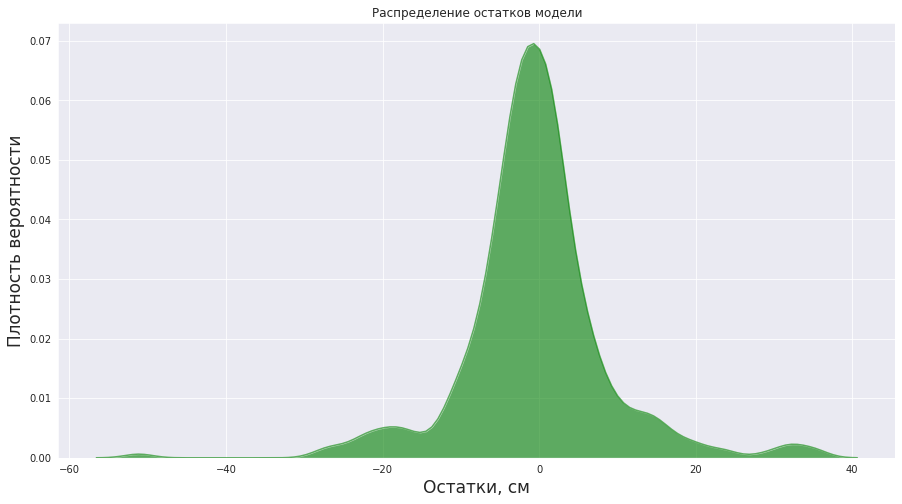

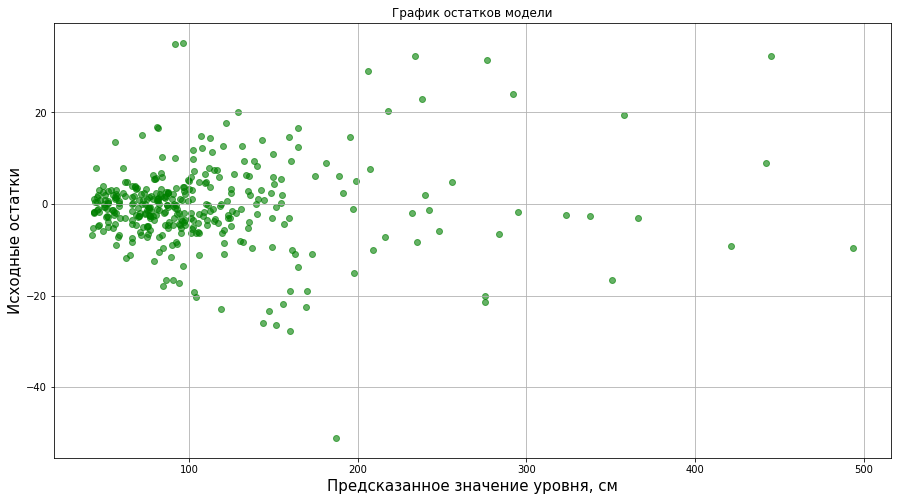

In [53]:
# Визуализируем остатки модели
residuals_plots(y_test, predicted, color = 'green')

Распределение остатков немного смещено левее относительно нуля (см. график распределения остатков), с другой стороны, соблюдается однородность дисперсии, плюс форму распределения считаю близкой к нормальной.

# Заключение

Итак, изначально мы обучили модель линейной регрессии, где в качестве предиктора выступал уровень воды на гидропосте Горелуха. Качество такой модели (средняя абсолютная ошибка) оказалось равным 16.7 см. Затем мы использовали полином 5й степени для аппроксимации зависимости и получили среднюю абсолютную ошибку на отложенной выборке 14.4 см. После добавления категориального признака (месяц) в модель линейной регрессии ошибка упала до 12.0 см. 

Улучшить качество еще на санитметр (до 11.0 см) помог синтез новых признаков, таких как: 
- Среднее значение температур за 10 суток
- Амплитуда температуры воздуха за 10 суток
- Сумма осадков за 10 суток
- Дисперсия осадков по выборке за 10 суток

Замена множественной линейной регрессии на метод опорных векторов позволила нам улучшить качество до 7.1 см. Добавление дополнительного категориального признака после анализа больших значений остатков модели позволило уменшить ошибку до 6.7 см.

Использование стекинга помогло достичь значения ошибки в 6.1 см